# 清单

* 框出问题看整体
* 获取数据
* 研究数据以获得深刻见解
* 准备数据以便更好地将潜在的数据模式给机器学习算法
* 探索许多不同的模型，并列出最佳模型
* 微调模型
* 演示方案
* 启动，监控，维护系统

## 框出问题看整体

predict median_house_value

## 获取数据

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [151]:
housing_df = pd.read_csv('./handson-ml2/datasets/housing/housing.csv')
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### 划分训练集和测试集

为了让之后添加新的数据后，划分的测试集不会掺杂到训练集中，导致模型学习到了测试集的内容。

可以采用对每行记录的唯一标识进行hash.md5处理，取MD5码最后一位的数值，如果小于 256 * 测试集比例， 则为测试集，反之为训练集

In [140]:
import hashlib

In [145]:
housing_df.duplicated().any()

False

In [152]:
housing_df['id'] = [''.join(np.array(i).astype('str')) for i in housing_df.values]

In [150]:
def train_test_split_hash(data, test_radio, unique_id_column):
    mask = data[unique_id_column].apply(lambda x: hashlib.md5(x.encode('utf8')).digest()[-1] < 256*test_radio)
    return data[~mask], data[mask]

In [154]:
housing_train, housing_test = train_test_split_hash(housing_df, .2, 'id')
print('training set shape: ', housing_train.shape)
print('test set shape：', housing_test.shape)

training set shape:  (16346, 11)
test set shape： (4294, 11)


## 研究数据

In [135]:
housing_ex = housing_df.copy()

### 查看有没有缺失值

In [136]:
housing_ex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


总记录数： 20640

total_bedrooms 只有 20433 个非空值，这里采用中位数来填充缺失值

In [137]:
housing_ex.total_bedrooms.fillna(housing_ex.total_bedrooms.median(), inplace=True)

In [138]:
housing_ex.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool

### 查看是否有重复数据

In [85]:
housing_ex.duplicated().any()

False

不存在重复记录

### 尝试新特征

In [133]:
housing_ex['bedrooms_per_room'] = housing_ex.total_bedrooms / housing_ex.total_rooms
housing_ex['rooms_per_households'] = housing_ex.total_rooms / housing_ex.households
housing_ex['population_per_households'] = housing_ex.population / housing_ex.households

### 处理分类特征

这个数据集中 ocean_proximity 不是数值类型，需要查看是否符合分类特征

In [87]:
housing_ex.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

可以看出ocean_proximity 可以划分为 5 类。

可以采用 get_dummies 进行 onehot编码

In [88]:
housing_ex_dum = pd.get_dummies(housing_ex)
housing_ex_dum.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,bedrooms_per_room,rooms_per_households,population_per_households,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,0.146591,6.984127,2.555556,0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,0.155797,6.238137,2.109842,0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,0.129516,8.288136,2.802260,0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,0.184458,5.817352,2.547945,0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,0.172096,6.281853,2.181467,0,0,0,1,0


### 查看相关性

In [98]:
housing_num_columns = list(housing_ex.columns)
housing_num_columns.remove('ocean_proximity')
housing_num = housing_ex[housing_num_columns]

In [100]:
corr = housing_num.corr()

In [101]:
corr.median_house_value

longitude                   -0.045967
latitude                    -0.144160
housing_median_age           0.105623
total_rooms                  0.134153
total_bedrooms               0.049457
population                  -0.024650
households                   0.065843
median_income                0.688075
median_house_value           1.000000
bedrooms_per_room           -0.255880
rooms_per_households         0.151948
population_per_households   -0.023737
Name: median_house_value, dtype: float64

In [102]:
import seaborn as sns

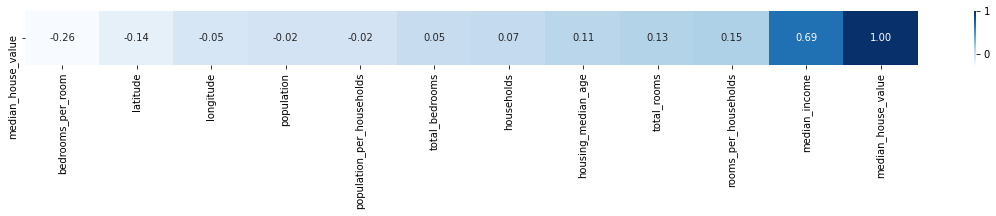

In [103]:
plt.figure(figsize=(20,1))
sns.heatmap(corr[['median_house_value']].sort_values('median_house_value').T, annot=True, fmt='.2f', cmap=plt.get_cmap('Blues'))
plt.show()

针对我们的目标值 median_house_value，与之相关性最强的 median_income， 表现为0.69 的相关性，

其次是新增的组合特征 bedrooms_per_room，相关系数 -0.26；

其它特征都没有表现出很强的相关性

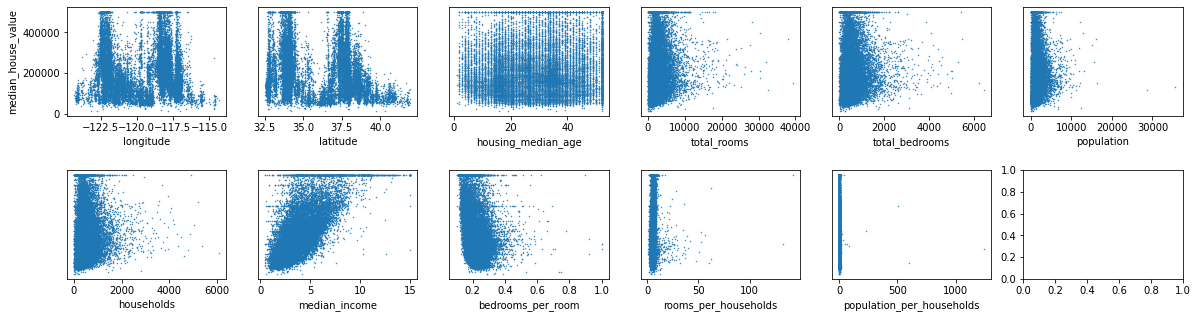

In [123]:
columns = list(housing_num.columns)
columns.remove('median_house_value')
fig,axes = plt.subplots(2,len(columns)//2 +1 if len(columns)%2 else len(columns)//2, figsize=(20,5))
for rank, column, ax in zip(range(len(columns)),columns, axes.ravel()):
    ax.scatter(housing_num[column], housing_num.median_house_value, s=.2)
    ax.set_xlabel(column)
    if rank == 0:
        ax.set_ylabel('median_house_value')
    if rank > 0:
        ax.axes.yaxis.set_visible(False)
plt.subplots_adjust(hspace=.5)
plt.show()

可以看出median_house_value 和median_income  大致呈线性正相关关系，其它特征并没有明显相关特点

另外可以看到median_income-median_house_value的图中，在最顶上呈一条水平直线分布，猜测是由于设定了median_house_value最大值，超过最大值都按最大值记录，所以这里把最大值部分去除，避免影响模型

### 处理异常值

In [125]:
housing_num.median_house_value.max()

500001.0

In [127]:
housing_num.median_house_value.value_counts().loc[housing_num.median_house_value.max()]

965

In [139]:
housing_notmax = housing_ex[housing_ex.median_house_value < housing_ex.median_house_value.max()]
housing_notmax.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19675 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           19675 non-null  float64
 1   latitude            19675 non-null  float64
 2   housing_median_age  19675 non-null  float64
 3   total_rooms         19675 non-null  float64
 4   total_bedrooms      19675 non-null  float64
 5   population          19675 non-null  float64
 6   households          19675 non-null  float64
 7   median_income       19675 non-null  float64
 8   median_house_value  19675 non-null  float64
 9   ocean_proximity     19675 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


## 准备数据

可以将上述对数据的清洗处理都利用转换器来处理，这里通过创建pipeline来创建模型

In [155]:
housing_pre = housing_train.copy()

### 处理缺失值

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
